In [1]:
import json
import collections
import itertools
import copy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
from scipy import stats
from scipy.misc import derivative

In [26]:
def unique_justseen(iterable, key=None):
    """List unique elements, preserving order. Remember only the element just seen."""
    # unique_justseen('AAAABBBCCDAABBB') --> A B C D A B
    # unique_justseen('ABBCcAD', str.lower) --> A B C A D
    return list(map(next, map(lambda x: x[1], itertools.groupby(iterable, key))))


def get_bins(iterable, nbins=1, key=lambda x: x, ceil_bin=False, full=False):
    vals = [key(x) for x in iterable]
    min_v = min(vals)
    max_v = max(vals)
    bin_size = ((1 + max_v - min_v) / float(nbins))
    bin_size = math.ceil(bin_size) if ceil_bin else bin_size
    bins = [[] for _ in range(nbins)]
    for c in iterable:
        cv = key(c)
        cbin = int((cv - min_v) / bin_size)
        bins[cbin].append(c)
    return bins if not full else (bins, bin_size, min_v, max_v, len(vals))

def get_distrib_fbins(iterable, bin_tup, non_zero=True):  # bins = bins, size, minv, maxv
    bins, size, minv, maxv, ln = bin_tup  # (idx+0.5)
    return [x for x in [(minv + (idx)*size, len(bins[idx])/float(ln)) for idx in range(len(bins))] if not non_zero or x[1] > 0]    

def get_distrib(iterable, nbins=100, key=lambda x: x, non_zero=True):
    inp = list(iterable)
    return get_distrib_fbins(iterable, get_bins(inp, nbins=nbins, key=key, full=True), non_zero=non_zero)

def get_bin_val(idx, bin_tup):
    return len(bin_tup[0][idx])/float(bin_tup[4])

def get_bin_data(x, bin_tup):
    idx = binize(x, bin_tup)
    if idx is None:
        return 0, None
    return get_bin_val(idx, bin_tup), idx

def binize(x, bin_tup):  # returns bin idx where the x lies, None if out of region
    bins, size, minv, maxv, ln = bin_tup
    if x < minv or x > maxv+size:
        return None
    return int((x - minv) // size)

def binned_pmf(x, bin_tup):
    return get_bin_data(x, bin_tup)[0]

def integrate_pmf(x, bin_tup):  # idea: sum all samples below + scale current bin
    pass

def get_bin_start(idx, bin_tup):
    return bin_tup[2] + idx * bin_tup[1]

def build_integrator(bin_tup, sums=None):
    sums = bin_sums(bin_tup) if sums is None else sums
    def cf(x):
        idx = binize(x, bin_tup)
        if idx is None: return 0
        subsum = 0 if idx <= 0 else sums[idx-1]
        curp = len(bin_tup[0][idx])/float(bin_tup[4])
        binstart = bin_tup[2] + idx * bin_tup[1]
        return subsum + curp*((x - binstart)/float(binsize))
    return cf

def bin_sums(bin_tup):
    binsums = []
    for ix in range(len(bin_tup[0])):
        cbin = len(bin_tup[0][ix])/float(bin_tup[4])
        cbin = (cbin + binsums[ix-1]) if ix > 0 else cbin
        binsums.append(cbin)
    return np.array(binsums) 
    
def is_crossed(pt, bound, direction):
    return (bound >= pt) if direction > 0 else (bound <= pt)
    
def move_bound(bnd, dx, direction):
    return bnd + dx if direction > 0 else bnd - dx
    
def all_diffs(vals):
    diffs, ln = [], len(vals)
    for i in range(ln):
        for j in range(i, ln):
            diffs.append(vals[i] - vals[j])
    return diffs
    
def pvalue_comp(fnc, extremes, dx, bin_tup, by_bins=True):
    """Extremes = [(val, direction +1\-1)] """
    nints = len(extremes)
    areas = [0] * nints
    nbounds = [x[0] for x in extremes]
    nbins = [binize(x[0], bin_tup) for x in extremes]
    bmin = min(nbounds)
    bmax = max(nbounds)
    cp = 0
    iterc = 0
    results = []
    print('OK: ', nints, nbins)
    
    while cp <= 1.0:  # integration step
        iterc += 1
        if iterc > 10000:
            raise ValueError('exc')  # Hard-termination to avoid infinite cycle.
        
        # Integration by increasing pvalue and tabulating.
        # Each area grows at the same pace. pvalue is a sum of areas.
        # Termination - bounds are crossing / touching.
        
        # Integrate each area with one step but in such a way the area is the same. 
        max_area = max(areas)
        min_area = min(areas)
        sum_area = sum(areas)
        err = max([abs(x) for x in all_diffs(areas)])
        areas_str = ['%.7f' % x for x in areas]
        #print('Main iter: %s, cp: %.7f, mina: %.7f, maxa: %.7f, suma: %.7f, err: %.7f, a: [%s], n: %s' 
        #      % (iterc, cp, min_area, max_area, sum_area, err, ', '.join(areas_str), nbins))
        
        subit = 0
        while any([x <= min_area for x in areas]):
            subit += 1
            #print('.. subit: %s' % subit)
            
            for ix in range(nints):
                if areas[ix] > min_area :
                    continue
                if by_bins:
                    areas[ix] += get_bin_val(nbins[ix], bin_tup)
                    nbounds[ix] = get_bin_start(nbins[ix], bin_tup)
                    nbins[ix] = move_bound(nbins[ix], 1, extremes[ix][1])
                else:
                    areas[ix] += fnc(nbounds[ix])
                    nbounds[ix] = move_bound(nbounds[ix], dx, extremes[ix][1])        
        cp = sum(areas)
        
        crit_int = [None]*nints
        for i in range(nints):
            crit_int[i] = (extremes[i][0], nbounds[i]) if extremes[i][1] > 0 else (nbounds[i], extremes[i][0])
            
        results.append((cp, crit_int, copy.deepcopy(areas), err))
        
    #print('Main iter: %s, cp: %s, mina: %s, maxa: %s, suma: %s, a: %s' 
    #          % (iterc, cp, min(areas), max(areas), sum(areas), areas))
    #print('Total: %s' % (sum([get_bin_val(ix, bin_tup) for ix in range(len(bin_tup[0]))])))
    #print(json.dumps(results, indent=2))
    return results


def tabulate_pvals(val, nbins=200, abs_val=False, target_pvals=[0.0,0.0001,0.0005,0.001,0.005,0.01]):
    inp_iter = val['zscores']
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    
    # Tabulate pvalues
    # build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)

    res_pdata = []
    for target in target_pvals:
        chosen = 0
        for i in range(len(pvals)):
            chosen = i
            if pvals[i][0] >= target:
                chosen = i - 1 if i > 0 else 0
                break
                
        cdata = pvals[chosen]
        res_pdata.append(collections.OrderedDict([
            ('pval_target', target),
            ('pval', cdata[0]),
            ('crit', cdata[1]),
            ('areas', cdata[2]),
            ('err', cdata[3]),
        ]))

    return collections.OrderedDict([
        ('method', val['method']), 
        ('block', val['block']),
        ('deg', val['deg']),
        ('comb_deg', val['comb_deg']),
        ('data_size', val['data_size']),
        ('nsamples', len(inp_iter)),
        ('nbins', nbins),
        ('abs_val', abs_val),
        ('binsize', bin_size),
        ('minv', minv),
        ('maxv', maxv),
        ('extremes', extremes),
        ('pvals', res_pdata)
    ])


In [3]:
js = json.load(open('ref_1554219251.json'))
csv = open('ref_1554219251.csv').read()

csv_data = []
for rec in [x.strip() for x in csv.split("\n")]:
    p = rec.split(';')
    if len(p) < 6:
        continue
    cur = collections.OrderedDict([
        ('method', p[0]), 
        ('block', int(p[1])),
        ('deg', int(p[2])),
        ('comb_deg', int(p[3])),
        ('data_size', int(p[4])),
        ('zscores', [float(x.replace(',','.')) for x in p[6:]])
    ])
    csv_data.append(cur)
print(json.dumps(csv_data[0]))  

{"method": "in0-kctr-ri1", "block": 128, "deg": 1, "comb_deg": 2, "data_size": 10, "zscores": [-3.77991]}


In [4]:
data = csv_data
data_filt = [x for x in data if x and len(x['zscores']) > 1000]
data_filt.sort(key=lambda x: (x['method'], x['block'], x['deg'], x['comb_deg'], x['data_size']))
np.random.seed(87655677)

In [28]:
pval_db = []
for dix, val in enumerate(data_filt):
    res = tabulate_pvals(val)
    pval_db.append(res)
    print('Dump %s' % dix)
json.dump(pval_db, open('pval_db.json', 'w+'), indent=2)

OK:  4 [0, 94, 94, 181]
(0.0007080720210398543, [(-5.059644, -5.059644), (-1.791716314999999, 0), (0, 1.8512194650000016), (4.636993885000002, 4.654873)], [0.00020230629172567267, 0.00010115314586283633, 0.000303459437588509, 0.00010115314586283633], 0)
Dump 0
OK:  4 [0, 88, 88, 183]
(0.001729106628242075, [(-5.522602, -5.522602), (-3.2170165600000002, 0), (0, 3.3258610400000004), (5.880698959999999, 5.940022)], [0.00023054755043227666, 0.00011527377521613833, 0.0012680115273775215, 0.00011527377521613833], 0)
Dump 1
OK:  4 [0, 93, 93, 184]
(0.0005214308061320263, [(-5.909561, -5.909561), (-3.051549125, 0), (0, 2.9820314999999997), (5.776532, 5.792714)], [0.00010428616122640526, 0.00020857232245281051, 0.00010428616122640526, 0.00010428616122640526], 0)
Dump 2
OK:  4 [0, 91, 91, 186]
(0.0009214702569878161, [(-6.626033, -6.626033), (-4.52993272, 0), (0, 4.43270296), (6.8179205199999995, 6.829831)], [0.00010238558410975735, 0.0004095423364390294, 0.000307156752329272, 0.0001023855841097

(0.0007255013732704566, [(-6.957857, -6.957857), (-4.51443965, 0), (0, 4.4447573), (6.8141317, 6.850733)], [5.182152666217547e-05, 0.00025910763331087733, 0.0003109291599730528, 0.00010364305332435094], 0)
Dump 35
OK:  4 [0, 95, 95, 186]
(0.002304147465437788, [(-6.873461, -6.873461), (-4.56035492, 0), (0, 4.475215704999999), (6.571468089999999, 6.583452)], [0.000576036866359447, 0.000576036866359447, 0.000576036866359447, 0.000576036866359447], 0)
Dump 36
OK:  4 [0, 92, 92, 186]
(0.002491280518186348, [(-7.04643, -7.04643), (-5.14771075, 0), (0, 5.02942443), (7.080041219999999, 7.143324)], [0.0004982561036372695, 0.0004982561036372695, 0.000996512207274539, 0.0004982561036372695], 0)
Dump 37
OK:  4 [0, 93, 93, 184]
(0.0029925187032418953, [(-5.997179, -5.997179), (-4.07097365, 0), (0, 3.890675129999999), (5.816880479999999, 5.84419)], [0.0014962593516209476, 0.0004987531172069825, 0.0004987531172069825, 0.0004987531172069825], 0)
Dump 38
OK:  4 [0, 94, 94, 187]
(0.00399400898652022, [

OK:  4 [0, 93, 93, 187]
(0.0006118702834998981, [(-7.269995, -7.269995), (-4.9389965, 0), (0, 4.851197200000001), (7.259895650000001, 7.269995)], [0.00010197838058331633, 0.00010197838058331633, 0.00030593514174994904, 0.00010197838058331633], 0)
Dump 88
OK:  4 [0, 92, 92, 187]
(0.008982035928143712, [(-7.282412, -7.282412), (-5.38378496, 0), (0, 5.375101600000002), (7.511057020000002, 7.53948)], [0.000998003992015968, 0.001996007984031936, 0.00499001996007984, 0.000998003992015968], 0)
Dump 89
OK:  4 [0, 94, 94, 189]
(0.005988023952095808, [(-9.197353, -9.197353), (-7.64224132, 0), (0, 7.617292039999999), (9.172403720000002, 9.241543)], [0.000998003992015968, 0.000998003992015968, 0.001996007984031936, 0.001996007984031936], 0)
Dump 90
OK:  4 [0, 89, 89, 181]
(0.0007339834329453706, [(-4.844062, -4.844062), (-2.3107286300000003, 0), (0, 2.2169310099999997), (4.91196651, 4.93608)], [0.0002097095522701059, 0.00010485477613505295, 0.0002097095522701059, 0.0002097095522701059], 0)
Dump 91

inctr-krnd-ri0[128:1:1:10]: 9886 
<class 'scipy.stats._distn_infrastructure.rv_discrete'>
[0. 0. 0.]
[0.00020231 0.00010115 0.00030346]
OK:  4 [0, 94, 94, 181]
inctr-krnd-ri0[128:1:1:10]: 9886 [ 4.63699389  4.31555838  3.77983253  3.35125185  3.08338892  1.85121947
 -6.059644    4.63699389 -5.059644   -4.36320039 -3.18460352  3.08338892]


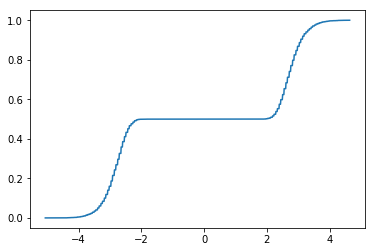

Plotting area under:  (0.09235282217276958, [(-5.059644, -3.6667567899999995), (-2.2738695799999995, 0), (0, 2.2262275600000008), (3.565542185000001, 4.654873)], [0.01992716973497876, 0.02346752984017803, 0.024580214444669228, 0.024377908152943554], 0.005259963584867491)


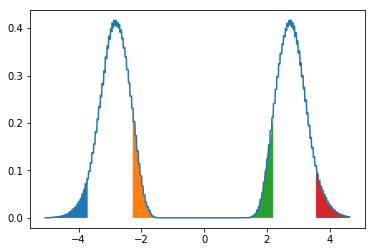

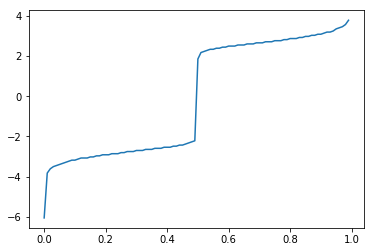

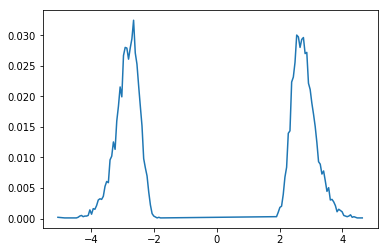

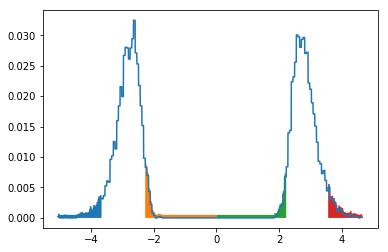

In [8]:
nbins = 200
abs_val = False
    
for dix, val in enumerate(data_filt):
    inp_iter = (val['zscores'])
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             '',#dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    dst = stats.rv_discrete(values=([x[0] for x in bb], [x[1] for x in bb]))
    print(stats.rv_discrete)
    
    x=np.array([bins[0], bins[1], bins[6]])
    print(dst.pmf(x))
    print(dst._pmf(x))
    
    # Tabulate pvalues
    build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)
    
    n_sample = 100
    rvs = dst.rvs(size=n_sample)
    f, l = np.histogram(rvs, bins=bins)
    f = np.append(f, [0])
    probs = np.array([x[1] for x in bb])
    #print(bins, len(bins))
    #print(probs, len(probs))
    #print(f, len(f))
    #sfreq = np.vstack([np.array([x[0] for x in bb]), f, probs*n_sample]).T
    #print(sfreq)
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    x = np.linspace(min(bins),max(bins),1000)
    plt.plot(x, dst.cdf(x))
    plt.show()
    
    cdf_dev = derivative(dst.cdf, x, dx=0.5)
    plt.plot(x,cdf_dev)
    
    sec_x = pvals[40]  # 49
    print('Plotting area under: ', sec_x)
    for ix in range(len(sec_x[1])):
        section = np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, derivative(dst.cdf, section, dx=0.5))
    plt.show()
    
    x = np.linspace(0,100,10000)
    plt.plot(x,dst.ppf(x))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(bins, dst._pmf(bins))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(x, [binned_pmf(y, bin_tup) for y in x])
    for ix in range(len(sec_x[1])):
        section = np.linspace(sec_x[1][ix][0], sec_x[1][ix][1], 10000) #np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, [binned_pmf(y, bin_tup)+0.0005 for y in section])
    plt.show()
    
    # Idea: pvalue function = pms of the distribution. 
    # If test returns z-score with p=0 then we reject the hypothesis as we didnt get such zscore
    # If test returns with p=0.3 we dont reject as we have our alpha set somehow...
    # Problem: number of bins. If too many, we have small probabilities -> some alphas not reachable.
    #if dix > 3:
    break
    

In [ ]:
np.arange(7)
#np.zeros(np.shape(0.5),'d')
#print(dst.ppf([1-0.01, 1-0.05, 1-0.10, 0.5, 0.6]))

In [ ]:
# Compute pvalues
def compute_pvals(dset):
    zs = sorted()
    pass

In [ ]:
a4_dims = (2*11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
zs = data_filt[1]['zscores']

for  i in range(1):
    zs = [x for x in data_filt[i]['zscores']]
    print(len(zs))
    sns.distplot(a=zs, ax=ax, hist=True, norm_hist=False, bins='auto')

# pvalues
 - pvalue = probability (in the null hypothesis distribution) to be observed as a value equal to or more extreme than the value observed
 
## computation 
 - Derive CDF -> find 0 regions = extremes
 - Integrate from 0 regions towards region of increasing integral value. 
 - Once sum of all integrations is alpha, stop. Integrated area is a critical region
 - Computation for x: integrate until the first integral boundary hits x. pvalue = sum of integrals
 - Tabulation: for each desired pvalue compute boundaries (4 values) where critical region starts. 
 - pvalue(x): need to do the integration OR function table (\forall zscores: P(zscore) > 0).
 - In our case 4 extremes, integrate: 
   - -\inf towards 0
   - +\inf towards 0
   - 0 towards +\inf
   - 0 towards -\inf
   - 10000 samples, pvalue = 0 -> 1/10000. 
 - absolutize -> we have a new distribution -> 2x more datapoints, 2 tails.  
  

In [6]:
np.arange(-1, 1, 1/20.)

array([-1.0000000e+00, -9.5000000e-01, -9.0000000e-01, -8.5000000e-01,
       -8.0000000e-01, -7.5000000e-01, -7.0000000e-01, -6.5000000e-01,
       -6.0000000e-01, -5.5000000e-01, -5.0000000e-01, -4.5000000e-01,
       -4.0000000e-01, -3.5000000e-01, -3.0000000e-01, -2.5000000e-01,
       -2.0000000e-01, -1.5000000e-01, -1.0000000e-01, -5.0000000e-02,
        8.8817842e-16,  5.0000000e-02,  1.0000000e-01,  1.5000000e-01,
        2.0000000e-01,  2.5000000e-01,  3.0000000e-01,  3.5000000e-01,
        4.0000000e-01,  4.5000000e-01,  5.0000000e-01,  5.5000000e-01,
        6.0000000e-01,  6.5000000e-01,  7.0000000e-01,  7.5000000e-01,
        8.0000000e-01,  8.5000000e-01,  9.0000000e-01,  9.5000000e-01])

In [19]:
keyCounter = [0] * 8

def inc(keyCounter):
    COUNTER_LENGTH = 8
    ln = COUNTER_LENGTH - 1
    while ln >= 0:
        keyCounter[ln] = (keyCounter[ln] + 1) % 16
        if (keyCounter[ln] != 0):
            return(keyCounter)
        ln-=1
    raise ValueError('finished')

for i in range(300):
    print(inc(keyCounter))


[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 3]
[0, 0, 0, 0, 0, 0, 0, 4]
[0, 0, 0, 0, 0, 0, 0, 5]
[0, 0, 0, 0, 0, 0, 0, 6]
[0, 0, 0, 0, 0, 0, 0, 7]
[0, 0, 0, 0, 0, 0, 0, 8]
[0, 0, 0, 0, 0, 0, 0, 9]
[0, 0, 0, 0, 0, 0, 0, 10]
[0, 0, 0, 0, 0, 0, 0, 11]
[0, 0, 0, 0, 0, 0, 0, 12]
[0, 0, 0, 0, 0, 0, 0, 13]
[0, 0, 0, 0, 0, 0, 0, 14]
[0, 0, 0, 0, 0, 0, 0, 15]
[0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 2]
[0, 0, 0, 0, 0, 0, 1, 3]
[0, 0, 0, 0, 0, 0, 1, 4]
[0, 0, 0, 0, 0, 0, 1, 5]
[0, 0, 0, 0, 0, 0, 1, 6]
[0, 0, 0, 0, 0, 0, 1, 7]
[0, 0, 0, 0, 0, 0, 1, 8]
[0, 0, 0, 0, 0, 0, 1, 9]
[0, 0, 0, 0, 0, 0, 1, 10]
[0, 0, 0, 0, 0, 0, 1, 11]
[0, 0, 0, 0, 0, 0, 1, 12]
[0, 0, 0, 0, 0, 0, 1, 13]
[0, 0, 0, 0, 0, 0, 1, 14]
[0, 0, 0, 0, 0, 0, 1, 15]
[0, 0, 0, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 0, 0, 2, 1]
[0, 0, 0, 0, 0, 0, 2, 2]
[0, 0, 0, 0, 0, 0, 2, 3]
[0, 0, 0, 0, 0, 0, 2, 4]
[0, 0, 0, 0, 0, 0, 2, 5]
[0, 0, 0, 0, 0, 0, 2, 6]
[0, 0, 0, 0, 0, 0, 2, 7]
[0, 0, 0, 0, 